In [175]:
import features as feat
import clusterize as clust

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph

from sklearn.metrics import silhouette_score

from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import math
import torch

FEATURES_PATH = "/home/guilherme/Mestrado/action_segmentation_app/data/RoadAccidents010_x264.mp4"

In [176]:
features = feat.Features(FEATURES_PATH).read()
features = StandardScaler().fit_transform(features)
features.shape, features.std(), features.mean(), features.min(), features.max()

((512, 2304), 1.0, -3.62181e-09, -3.710279, 5.5677643)

In [137]:
def positional_encoding(data):
    d_model = data.shape[1]
    length = data.shape[0]
    
    pe = torch.zeros(length, d_model)
    position = torch.arange(0, length).unsqueeze(1)
    den_exp = torch.exp((torch.arange(0, d_model, 2, dtype=torch.float) *
                            -(math.log(10000.0) / d_model)))
    pe[:, 0::2] = torch.sin(position.float() * den_exp)
    pe[:, 1::2] = torch.cos(position.float() * den_exp)
    
    return data + pe.numpy()

In [177]:
pos_enc_features = positional_encoding(features)

In [178]:
def dim_reduction(data):
    pca = PCA(n_components=50)
    reduced_features = pca.fit_transform(data)

    tsne = TSNE(n_components=2, perplexity=50)
    vis_features = tsne.fit_transform(reduced_features)
    return vis_features


def bic_estimate_clusters(data):
    
    bics = []
    min_bic = math.inf
    min_bic_model = None
    
    for n in range(1, 13):
        estimator = GaussianMixture(n_components=n)
        estimator.fit(data)
        bics.append(estimator.bic(data))    
        
        if bics[-1] < min_bic:
            min_bic = bics[-1]
            min_bic_model = estimator
        
        print(n)

    red_data = dim_reduction(data)
    
    c_df = pd.DataFrame()
    c_df['BIC'] = bics
    c_df['n_components'] = list(range(1, n+1))
    
    vis_df = pd.DataFrame(red_data, columns=["x", "y"])
    vis_df["labels"] = min_bic_model.predict(data)    

    return vis_df, c_df

In [189]:
def silh_estimate_clusters(data):
    
    sils = []
    max_sil = -math.inf
    max_sil_model = None
    not_inc_iter = 0
    upper_clust_lim = int(data.shape[0] / 16 * 0.5)
#     batch_size = int(data.shape[0] * 0.1)
    
    for n in range(2, upper_clust_lim):
#         estimator = KMeans(n_clusters=n, random_state=42)
        estimator = AgglomerativeClustering(n_clusters=n, linkage='average', affinity='cosine')
#         estimator = GaussianMixture(n_components=n, random_state=42)
        estimator.fit(data)
        sils.append(silhouette_score(data, estimator.labels_))    
        
        if sils[-1] > max_sil:  # new silhoutte must be at least 5% greater than silhoutte of simpler model
            max_sil = sils[-1]
            max_sil_model = estimator
            not_inc_iter = 0
        else:
            not_inc_iter += 1
        
        if not_inc_iter >= 3:
            break
        
        print(n, not_inc_iter)

    red_data = dim_reduction(data)
    
    c_df = pd.DataFrame()
    c_df['silhouette'] = sils
    c_df['n_components'] = list(range(2, n+1))
    
    
    vis_df = pd.DataFrame(red_data, columns=["x", "y"])
    vis_df["labels"] = max_sil_model.labels_    

    return vis_df, c_df

In [180]:
def bayesian_mixture(data):
    upper_clust_lim = int(data.shape[0] / 16 * 0.5)
    estimator = BayesianGaussianMixture(n_components=upper_clust_lim, random_state=42)
    estimator.fit(data)
    
    red_data = dim_reduction(data)
    vis_df = pd.DataFrame(red_data, columns=["x", "y"])
    vis_df["labels"] = estimator.predict(data) 
    
    return vis_df

In [181]:
def dbscan(data):
    estimator = DBSCAN(eps=5e1, min_samples=16)
    estimator.fit(data)
    
    red_data = dim_reduction(data)
    vis_df = pd.DataFrame(red_data, columns=["x", "y"])
    vis_df["labels"] = estimator.labels_ 
    
    return vis_df

In [191]:
vis_df, c_df = silh_estimate_clusters(data=features)

2 0
3 0
4 0
5 1
6 2


In [190]:
pos_vis_df, pos_c_df = silh_estimate_clusters(data=pos_enc_features)

2 0
3 0
4 0
5 1
6 2


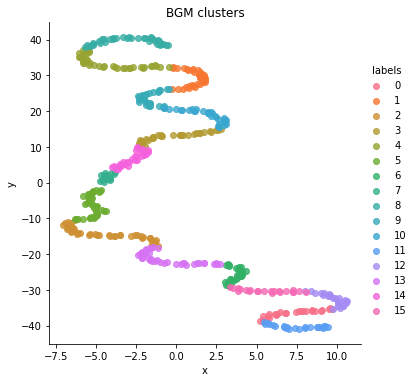

In [142]:
pos_vis_df = bayesian_mixture(pos_enc_features)
sns.lmplot(data=pos_vis_df, x='x', y='y', hue='labels', 
           x_jitter=.3, y_jitter=.3,
           fit_reg=False, legend=True, legend_out=True).set(title="BGM clusters")

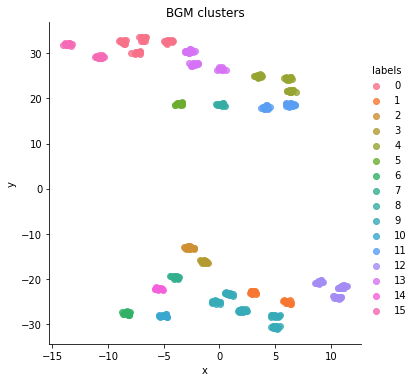

In [147]:
pos_vis_df = bayesian_mixture(features)
sns.lmplot(data=pos_vis_df, x='x', y='y', hue='labels', 
           x_jitter=.3, y_jitter=.3,
           fit_reg=False, legend=True, legend_out=True).set(title="BGM clusters")

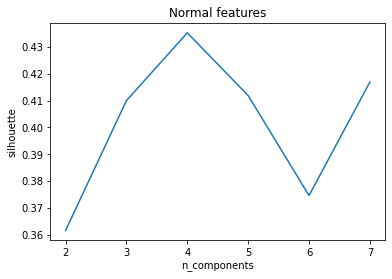

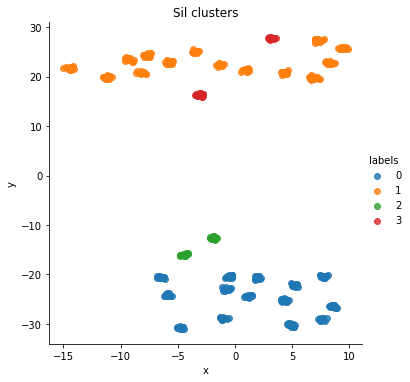

In [192]:
sns.lineplot(y='silhouette', x='n_components', data=c_df).set(title="Normal features")
sns.lmplot(data=vis_df, x='x', y='y', hue='labels', 
           x_jitter=.3, y_jitter=.3,
           fit_reg=False, legend=True, legend_out=True).set(title="Sil clusters")

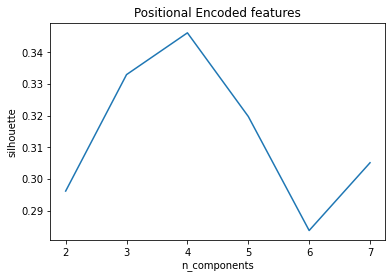

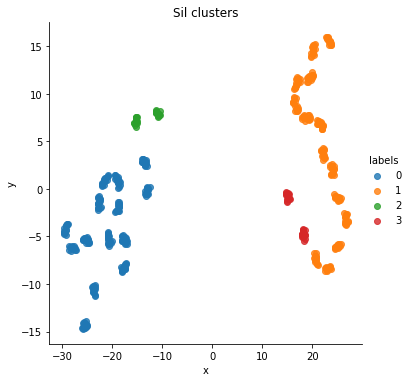

In [193]:
sns.lineplot(y='silhouette', x='n_components', data=pos_c_df).set(title="Positional Encoded features")
sns.lmplot(data=pos_vis_df, x='x', y='y', hue='labels', 
           x_jitter=.3, y_jitter=.3,
           fit_reg=False, legend=True, legend_out=True).set(title="Sil clusters")

In [209]:
from external.KTS.cpd_auto import cpd_auto
from external.KTS.cpd_auto import estimate_vmax

In [257]:
def compute_change_points(data: np.ndarray) -> tuple:
    """ Given a 2D numpy array of features this method computes the change
    points for a video with the algorithm KTS
    Args:
        features: 2D numpy array representing the features of a video
    Returns:
        a tuple with a list of the change points and a list with scores of
        each change point. The change points are the x indices in the fea-
        -tures numpy array.
    """
    upper_clust_lim = int(data.shape[0] / 16 * 0.5)
    k_data = np.dot(data, data.T)
    vmax = estimate_vmax(k_data)
    print(vmax)
    cps, scores = cpd_auto(k_data, ncp=upper_clust_lim, vmax=vmax, lmin=30, lmax=upper_clust_lim * 16)
    return cps, scores

In [258]:
cps, scores = compute_change_points(pos_enc_features)
len(cps), cps, scores

2971.0
Precomputing scatters...
Inferring best change points...
Precomputing scatters...
Inferring best change points...


(15,
 array([ 32,  64,  96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 416,
        448, 480]),
 array([          inf,           inf, 1815.31141983, 1635.91671397,
        1488.20923336, 1344.78554352, 1255.51685051, 1187.55776225,
        1130.74509444, 1086.35892033, 1045.1367544 , 1009.03869141,
         992.29785131,  975.38565923,  959.99762302,  950.49250175,
        1051.69332215]))

In [221]:
compute_change_points(pos_enc_features)

2971.0
Precomputing scatters...
Inferring best change points...
Precomputing scatters...
Inferring best change points...


(array([ 32,  48,  96, 160, 176, 192, 208, 224, 240, 256, 272, 288, 320,
        368, 416, 480]),
 array([2970.99977255, 2100.53192667, 1777.34427723, 1582.49402167,
        1412.3422872 , 1255.18144097, 1141.23404672, 1042.24921682,
         960.26161563,  879.63477879,  821.97802829,  765.70342282,
         710.89083942,  658.32760633,  610.95452938,  568.97363521,
         539.73940034]))

In [12]:
def get_segments(data: np.ndarray):
    """ Get continuous time intervals (segments) from a video
    
    args:
    data - label of each segment
    labels - the unique labels
    
    return:
    segs - dict of list of tuples, where each key is a label and tuple is a continuous segment 
    """
    segs = []
    for label in np.unique(data):
        idxs = np.where(data == label)[0]
        curr = idxs[0]
        last = None
        step = 0
        for idx in idxs:
            if idx != curr + step:
                segs.append({label: (curr, last)})
                curr = idx
                step = 1
                last = None
            else:
                last = idx
                step += 1

        segs.append({label: (curr, idx)})
    segs.sort(key=lambda value: list(value.values())[0])
    return segs

In [13]:
get_segments(gm_labels)

[{1: (0, 47)},
 {5: (48, 191)},
 {3: (192, 239)},
 {2: (240, 255)},
 {0: (256, 271)},
 {4: (272, 335)},
 {0: (336, 511)}]

In [4]:
from video import Video

In [6]:
v = Video(FEATURES_PATH)
paths = v.clusters_to_videos(labels)

save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save


FileNotFoundError: [Errno 2] No such file or directory: 'home/guilherme/Mestrado/action_segmentation_app/data/RoadAccidents010_x264.mp4_segments/temp_1_0_175_RoadAccidents010_x264.mp4'

In [54]:
get_segments(labels)

[{1: (0, 175)},
 {4: (176, 191)},
 {1: (192, 223)},
 {2: (224, 255)},
 {5: (256, 271)},
 {3: (272, 367)},
 {0: (368, 511)}]

In [26]:
get_segments(sc_labels, np.unique(sc_labels))

{0: [(240, 255)],
 1: [(0, 15), (368, 415)],
 2: [(48, 63), (144, 159), (256, 271), (448, 479)],
 3: [(32, 47), (64, 143), (160, 239), (272, 351), (416, 447), (480, 511)],
 4: [(16, 31)],
 5: [(352, 367)]}